In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import os

num_skipped = 0
for folder_name in ("Car", "Ship"):
    folder_path = os.path.join("CarShipImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
image_size = (180, 180)
batch_size = 128

train_ds= tf.keras.utils.image_dataset_from_directory(
    "CarShipImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "CarShipImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 16288 files belonging to 2 classes.
Using 13031 files for training.
Found 16288 files belonging to 2 classes.
Using 3257 files for validation.


tf.Tensor(
[0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0
 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0
 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0
 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0], shape=(128,), dtype=int32)


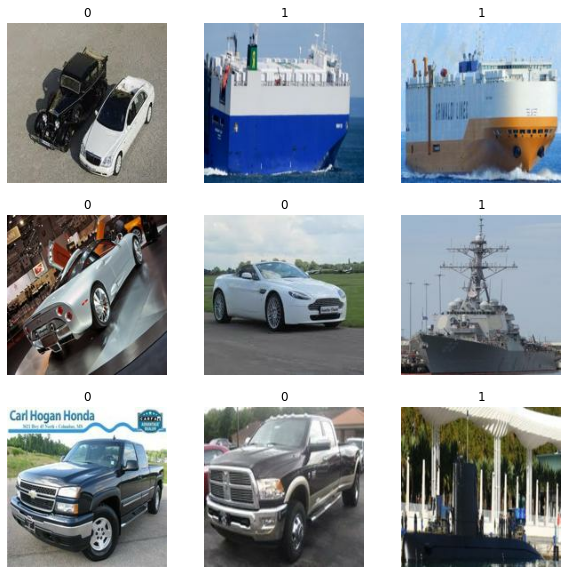

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
print (labels)

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

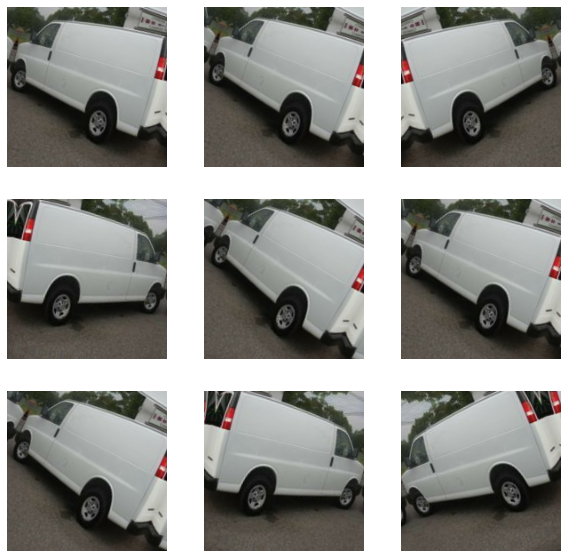

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
inputs = keras.Input(shape=( (180,180)))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [9]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
base_model = InceptionV3(input_shape = (180, 180, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(728, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])


In [17]:
epochs = 10

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
# ]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    # callbacks=callbacks,
    steps_per_epoch = 10,
    validation_data=val_ds,
)

Epoch 1/10
10/10 [==============================] - 93s 10s/step - loss: 0.3908 - accuracy: 0.8578 - val_loss: 0.9029 - val_accuracy: 0.7685
Epoch 2/10
10/10 [==============================] - 92s 10s/step - loss: 0.3118 - accuracy: 0.8844 - val_loss: 1.9719 - val_accuracy: 0.6524
Epoch 3/10
10/10 [==============================] - 92s 10s/step - loss: 0.2716 - accuracy: 0.8977 - val_loss: 0.3014 - val_accuracy: 0.8910
Epoch 4/10
10/10 [==============================] - 92s 10s/step - loss: 0.2534 - accuracy: 0.8984 - val_loss: 0.4285 - val_accuracy: 0.8563
Epoch 5/10
10/10 [==============================] - 92s 10s/step - loss: 0.2271 - accuracy: 0.9070 - val_loss: 0.6303 - val_accuracy: 0.8250
Epoch 6/10
10/10 [==============================] - 92s 10s/step - loss: 0.2471 - accuracy: 0.8992 - val_loss: 0.3713 - val_accuracy: 0.8692
Epoch 7/10
10/10 [==============================] - 92s 10s/step - loss: 0.2479 - accuracy: 0.9000 - val_loss: 0.5245 - val_accuracy: 0.8397
Epoch 8/10
10

In [15]:
model.save('model5.h5')

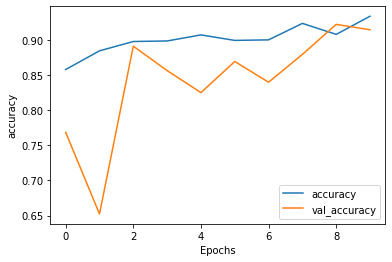

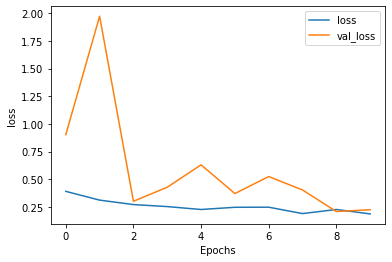

In [18]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(model.history, "accuracy")
plot_graphs(model.history, "loss")

In [21]:
from keras.models import load_model
model = load_model('model5.h5')
img = keras.preprocessing.image.load_img(
    "CarShipImages/Car/405.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% car and {100 * score:.2f}% ship.")

1/1 [==============================] - 2s 2s/step
This image is 100.00% car and 0.00% ship.
